In [1]:
!pip install torchmetrics
!pip install torch-fidelity
!pip install torch torchvision numpy matplotlib scikit-learn scipy

In [2]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics import MeanSquaredError

In [3]:
#Imports libraries for data handling (os, numpy), PyTorch (torch, torch.nn, etc.), dataset management (Dataset, DataLoader), splitting (train_test_split), visualization (matplotlib), and FID computation (torch_fidelity).
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn.functional as F
import torch_fidelity
import shutil
from PIL import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
simulated_lr_dir = "/kaggle/input/dataset-image-super-resolution-3a/Dataset/LR"
simulated_hr_dir = "/kaggle/input/dataset-image-super-resolution-3a/Dataset/HR"

Sample: sample1
LR Image Shape: (1, 75, 75), HR Image Shape: (1, 150, 150)
LR Image Min: 0.0045, Max: 0.9734
HR Image Min: 0.0000, Max: 1.0000



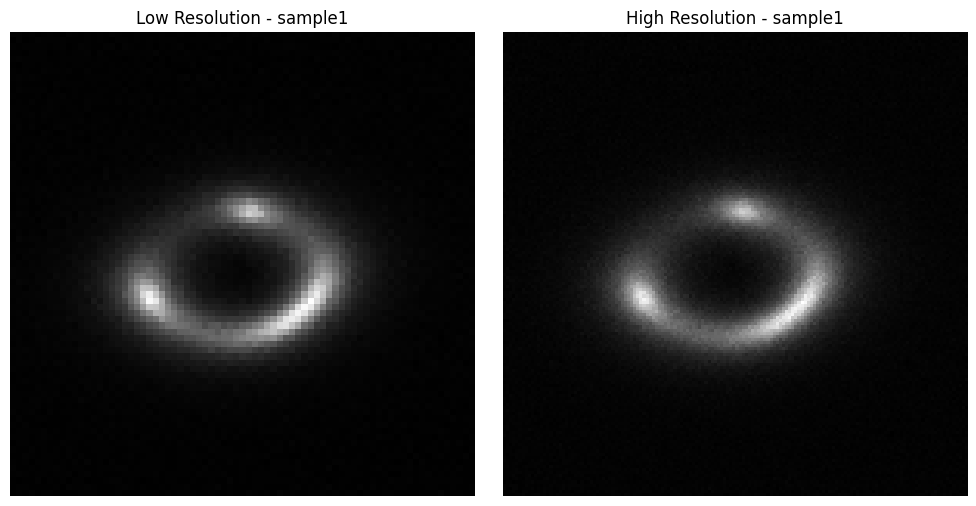

Sample: sample10
LR Image Shape: (1, 75, 75), HR Image Shape: (1, 150, 150)
LR Image Min: 0.0042, Max: 1.0184
HR Image Min: 0.0000, Max: 1.0000



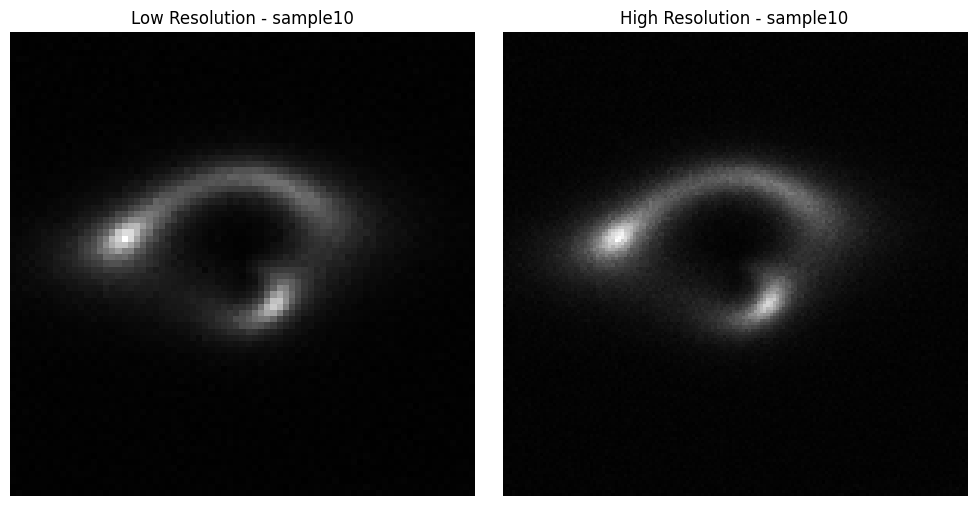

Sample: sample100
LR Image Shape: (1, 75, 75), HR Image Shape: (1, 150, 150)
LR Image Min: 0.0021, Max: 1.0088
HR Image Min: 0.0000, Max: 1.0000



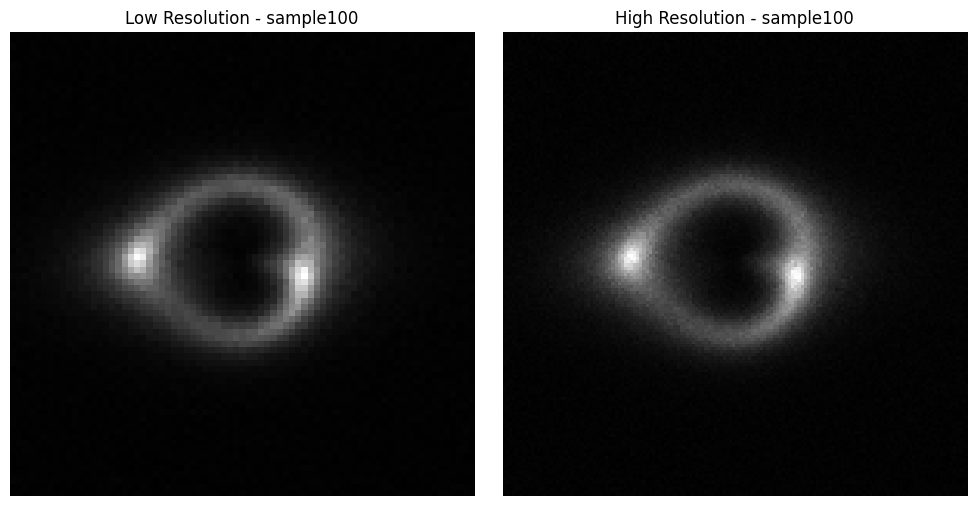

In [7]:
def load_npy_file(filepath):
    return np.load(filepath)


def visualize_image_pairs(lr_image, hr_image, sample_name):
    if lr_image.ndim == 3 and lr_image.shape[0] == 1:
        lr_image = lr_image[0]
    if hr_image.ndim == 3 and hr_image.shape[0] == 1:
        hr_image = hr_image[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(lr_image, cmap='gray')
    axes[0].set_title(f"Low Resolution - {sample_name}")
    axes[0].axis('off')
    
    axes[1].imshow(hr_image, cmap='gray')
    axes[1].set_title(f"High Resolution - {sample_name}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


sample_names = ["sample1", "sample10", "sample100"]
for sample in sample_names:
    lr_path = os.path.join(simulated_lr_dir, f"{sample}.npy")
    hr_path = os.path.join(simulated_hr_dir, f"{sample}.npy")
    
    if os.path.exists(lr_path) and os.path.exists(hr_path):
        lr_image = load_npy_file(lr_path)
        hr_image = load_npy_file(hr_path)
        print(f"Sample: {sample}")
        print(f"LR Image Shape: {lr_image.shape}, HR Image Shape: {hr_image.shape}")
        print(f"LR Image Min: {lr_image.min():.4f}, Max: {lr_image.max():.4f}")
        print(f"HR Image Min: {hr_image.min():.4f}, Max: {hr_image.max():.4f}\n")
        
        visualize_image_pairs(lr_image, hr_image, sample)
    else:
        print(f"Files for {sample} not found. Check paths: {lr_path}, {hr_path}")

In [8]:
lr_files = sorted([os.path.join(simulated_lr_dir, f) for f in os.listdir(simulated_lr_dir) if f.endswith('.npy')])
hr_files = sorted([os.path.join(simulated_hr_dir, f) for f in os.listdir(simulated_hr_dir) if f.endswith('.npy')])
assert len(lr_files) == len(hr_files) == 10000, "LR/HR mismatch"

indices = list(range(10000))
train_idx, temp_idx = train_test_split(indices, test_size=2000, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=1000, random_state=42)

In [9]:
class LensingDataset(Dataset):
    def __init__(self, file_paths, is_lr=True):
        self.file_paths = file_paths
        self.is_lr = is_lr
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img = np.load(self.file_paths[idx]).astype(np.float32)
        
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = np.zeros_like(img)
        
        img = torch.from_numpy(img)
        return img

In [11]:
lr_dataset = LensingDataset([lr_files[i] for i in indices], is_lr=True)
hr_dataset = LensingDataset([hr_files[i] for i in indices], is_lr=False)

lr_train_dataset = Subset(lr_dataset, train_idx)
lr_val_dataset = Subset(lr_dataset, val_idx)
lr_test_dataset = Subset(lr_dataset, test_idx)

hr_train_dataset = Subset(hr_dataset, train_idx)
hr_val_dataset = Subset(hr_dataset, val_idx)
hr_test_dataset = Subset(hr_dataset, test_idx)

lr_train_loader = DataLoader(lr_train_dataset, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
hr_train_loader = DataLoader(hr_train_dataset, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
lr_val_loader = DataLoader(lr_val_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
hr_val_loader = DataLoader(hr_val_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
lr_test_loader = DataLoader(lr_test_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
hr_test_loader = DataLoader(hr_test_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

In [12]:
class ResNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_blocks=9):
        super(ResNetGenerator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 7, padding=3, padding_mode='reflect')
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.down = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, 256, 3, padding=1, padding_mode='reflect'),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, 3, padding=1, padding_mode='reflect'),
                nn.BatchNorm2d(256)
            ) for _ in range(num_blocks)
        ])
        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.down_for_hr = nn.Sequential(
            nn.Conv2d(256, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv_out = nn.Conv2d(64, out_channels, 7, padding=3, padding_mode='reflect')
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        assert x.shape[1] == 1, f"Expected 1 input channel, got {x.shape[1]}"
        assert x.shape[2] in [75, 150], f"Expected spatial size 75 or 150, got {x.shape[2]}"
        
        out = self.conv1(x)
        assert out.shape[1] == 64, f"After conv1, expected 64 channels, got {out.shape[1]}"
        assert out.shape[2] == x.shape[2], f"After conv1, expected spatial size {x.shape[2]}, got {out.shape[2]}"
        
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.down(out)
        expected_down_size = 19 if x.shape[2] == 75 else 38
        assert out.shape[1] == 256, f"After down, expected 256 channels, got {out.shape[1]}"
        assert out.shape[2] == expected_down_size, f"After down, expected spatial size {expected_down_size}, got {out.shape[2]}"
        
        for block in self.res_blocks:
            residual = out
            assert out.shape[1] == 256, f"Before res_block, expected 256 channels, got {out.shape[1]}"
            out = block(out)
            assert out.shape[1] == 256, f"After res_block, expected 256 channels, got {out.shape[1]}"
            assert out.shape[2] == expected_down_size, f"After res_block, expected spatial size {expected_down_size}, got {out.shape[2]}"
            out = out + residual
        
        if x.shape[2] == 75:
            out = self.up(out)
            out = F.interpolate(out, size=(150, 150), mode='bilinear', align_corners=False)
            assert out.shape[1] == 64, f"After up, expected 64 channels, got {out.shape[1]}"
            assert out.shape[2] == 150, f"After up, expected spatial size 150, got {out.shape[2]}"
        
        if x.shape[2] == 150:
            out = self.down_for_hr(out)
            assert out.shape[1] == 64, f"After down_for_hr, expected 64 channels, got {out.shape[1]}"
        
        out = self.conv_out(out)
        assert out.shape[1] == 1, f"After conv_out, expected 1 channel, got {out.shape[1]}"
        
        if x.shape[2] == 150:
            out = F.interpolate(out, size=(75, 75), mode='bilinear', align_corners=False)
            assert out.shape[2] == 75, f"After HR downsample, expected spatial size 75, got {out.shape[2]}"
        
        out = self.tanh(out)
        return out

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)

In [14]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:29].eval()
        self.vgg = vgg.to("cuda")
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse = nn.MSELoss()
    
    def forward(self, x, y):
        x = x.repeat(1, 3, 1, 1)
        y = y.repeat(1, 3, 1, 1)
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.mse(x_features, y_features)

In [15]:
class PhysicsLoss(nn.Module):
    def __init__(self):
        super(PhysicsLoss, self).__init__()
        self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).cuda()
        self.sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).cuda()
        self.mse = nn.MSELoss()
    
    def forward(self, sr, lr):
        lr = F.interpolate(lr, size=(150, 150), mode='bilinear', align_corners=False)
        sr_grad_x = F.conv2d(sr, self.sobel_x, padding=1)
        sr_grad_y = F.conv2d(sr, self.sobel_y, padding=1)
        lr_grad_x = F.conv2d(lr, self.sobel_x, padding=1)
        lr_grad_y = F.conv2d(lr, self.sobel_y, padding=1)
        sr_grad = torch.sqrt(sr_grad_x**2 + sr_grad_y**2 + 1e-8) 
        lr_grad = torch.sqrt(lr_grad_x**2 + lr_grad_y**2 + 1e-8)
        sr_grad = torch.nan_to_num(sr_grad, nan=0.0)  
        lr_grad = torch.nan_to_num(lr_grad, nan=0.0)
        return self.mse(sr_grad, lr_grad)


In [16]:
G_A = ResNetGenerator().to(device)  # LR→HR
G_B = ResNetGenerator().to(device)  # HR→LR
D_A = Discriminator().to(device)    # HR discriminator
D_B = Discriminator().to(device)    # LR discriminator

adversarial_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()
vgg_criterion = PerceptualLoss()
physics_criterion = PhysicsLoss()

optimizer_G = optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))


lambda_cycle = 10.0
lambda_vgg = 0.1
lambda_physics = 0.05

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 196MB/s]  


In [23]:
def train_cyclegan(epochs, use_physics=False, start_epoch=0):
    G_A.train()
    G_B.train()
    D_A.train()
    D_B.train()
    
    print(f"\n=== Training CycleGAN (Use Physics: {use_physics}) ===")
    print(f"Models on device: {next(G_A.parameters()).device}")
    print(f"Initial VRAM usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    
    losses_G, losses_D_A, losses_D_B = [], [], []
    cycle_losses, vgg_losses, physics_losses = [], [], []
    
    scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=2, gamma=0.5)
    scheduler_D_A = optim.lr_scheduler.StepLR(optimizer_D_A, step_size=2, gamma=0.5)
    scheduler_D_B = optim.lr_scheduler.StepLR(optimizer_D_B, step_size=2, gamma=0.5)
    
    for epoch in range(start_epoch, epochs):
        epoch_loss_G, epoch_loss_D_A, epoch_loss_D_B = 0, 0, 0
        epoch_cycle_loss, epoch_vgg_loss, epoch_physics_loss = 0, 0, 0
        
        lr_iter = iter(lr_train_loader)
        hr_iter = iter(hr_train_loader)
        
        for step in range(len(lr_train_loader)):
            try:
                lr = next(lr_iter).to(device)
            except StopIteration:
                lr_iter = iter(lr_train_loader)
                lr = next(lr_iter).to(device)
            try:
                hr = next(hr_iter).to(device)
            except StopIteration:
                hr_iter = iter(hr_train_loader)
                hr = next(hr_iter).to(device)
            
            optimizer_D_A.zero_grad()
            optimizer_D_B.zero_grad()
            
            real_A = hr
            real_B = lr
            label_real_A = torch.ones_like(D_A(real_A), device=device)
            label_fake_A = torch.zeros_like(label_real_A, device=device)
            label_real_B = torch.ones_like(D_B(real_B), device=device)
            label_fake_B = torch.zeros_like(label_real_B, device=device)
            
            fake_A = G_A(real_B)
            fake_B = G_B(real_A)
            
            loss_D_A_real = adversarial_criterion(D_A(real_A), label_real_A)
            loss_D_A_fake = adversarial_criterion(D_A(fake_A.detach()), label_fake_A)
            loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
            loss_D_A.backward()
            torch.nn.utils.clip_grad_norm_(D_A.parameters(), max_norm=1.0)
            optimizer_D_A.step()
            
            loss_D_B_real = adversarial_criterion(D_B(real_B), label_real_B)
            loss_D_B_fake = adversarial_criterion(D_B(fake_B.detach()), label_fake_B)
            loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
            loss_D_B.backward()
            torch.nn.utils.clip_grad_norm_(D_B.parameters(), max_norm=1.0)
            optimizer_D_B.step()
            
            optimizer_G.zero_grad()
            
            loss_G_A = adversarial_criterion(D_A(fake_A), label_real_A)
            loss_G_B = adversarial_criterion(D_B(fake_B), label_real_B)
            loss_G_adv = loss_G_A + loss_G_B
            
            recon_A = G_A(fake_B)
            recon_B = G_B(fake_A)
            loss_cycle_A = cycle_criterion(recon_A, real_A)
            loss_cycle_B = cycle_criterion(recon_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle
            
            loss_vgg_A = vgg_criterion(fake_A, real_A)
            loss_vgg_B = vgg_criterion(fake_B, real_B)
            loss_vgg = (loss_vgg_A + loss_vgg_B) * lambda_vgg
            
            loss_G = loss_G_adv + loss_cycle + loss_vgg
            
            if use_physics:
                lambda_physics = 0.05 
                loss_physics = physics_criterion(fake_A, real_B) * lambda_physics
                loss_G += loss_physics
            else:
                loss_physics = torch.tensor(0.0)
            
            loss_G.backward()
            torch.nn.utils.clip_grad_norm_(list(G_A.parameters()) + list(G_B.parameters()), max_norm=1.0)
            optimizer_G.step()
            
            epoch_loss_G += loss_G.item()
            epoch_loss_D_A += loss_D_A.item()
            epoch_loss_D_B += loss_D_B.item()
            epoch_cycle_loss += loss_cycle.item()
            epoch_vgg_loss += loss_vgg.item()
            epoch_physics_loss += loss_physics.item()
            
            if (step + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Step {step+1}/{len(lr_train_loader)}, "
                      f"Loss G: {loss_G.item():.4f}, Loss D_A: {loss_D_A.item():.4f}, Loss D_B: {loss_D_B.item():.4f}, "
                      f"Cycle: {loss_cycle.item():.4f}, VGG: {loss_vgg.item():.4f}, Physics: {loss_physics.item():.4f}")
        
        scheduler_G.step()
        scheduler_D_A.step()
        scheduler_D_B.step()
        
        epoch_loss_G /= len(lr_train_loader)
        epoch_loss_D_A /= len(lr_train_loader)
        epoch_loss_D_B /= len(lr_train_loader)
        epoch_cycle_loss /= len(lr_train_loader)
        epoch_vgg_loss /= len(lr_train_loader)
        epoch_physics_loss /= len(lr_train_loader)
        
        losses_G.append(epoch_loss_G)
        losses_D_A.append(epoch_loss_D_A)
        losses_D_B.append(epoch_loss_D_B)
        cycle_losses.append(epoch_cycle_loss)
        vgg_losses.append(epoch_vgg_loss)
        physics_losses.append(epoch_physics_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss G: {epoch_loss_G:.4f}, D_A: {epoch_loss_D_A:.4f}, D_B: {epoch_loss_D_B:.4f}, "
              f"Cycle: {epoch_cycle_loss:.4f}, VGG: {epoch_vgg_loss:.4f}, Physics: {epoch_physics_loss:.4f}")
        
        with torch.no_grad():
            G_A.eval()
            lr_sample = next(iter(lr_val_loader)).to(device)
            sr_sample = G_A(lr_sample)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(lr_sample[0, 0].cpu().numpy(), cmap="gray")
            plt.title("LR")
            plt.subplot(1, 2, 2)
            plt.imshow(sr_sample[0, 0].cpu().numpy(), cmap="gray")
            plt.title("SR")
            plt.savefig(f"original_physics_informed_cyclegan_sr_epoch{epoch+1}.png")
            plt.close()
            G_A.train()
        
        if (epoch + 1) % 5 == 0:
            torch.save({
                'G_A': G_A.state_dict(),
                'G_B': G_B.state_dict(),
                'D_A': D_A.state_dict(),
                'D_B': D_B.state_dict(),
                'optimizer_G': optimizer_G.state_dict(),
                'optimizer_D_A': optimizer_D_A.state_dict(),
                'optimizer_D_B': optimizer_D_B.state_dict(),
                'epoch': epoch + 1
            }, f"original_physics_informed_cyclegan_epoch{epoch+1}.pth")
    
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label="Generator Loss")
    plt.plot(losses_D_A, label="Discriminator A Loss")
    plt.plot(losses_D_B, label="Discriminator B Loss")
    plt.plot(cycle_losses, label="Cycle Loss")
    plt.plot(vgg_losses, label="VGG Loss")
    if use_physics:
        plt.plot(physics_losses, label="Physics Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig(f"original_physics_informed_cyclegan_loss_curves_epoch{epochs}.png")
    plt.close()

In [17]:
train_cyclegan(epochs=15, use_physics=False)


=== Training CycleGAN (Use Physics: False) ===
Models on device: cuda:0
Initial VRAM usage: 353.25 MB
Epoch 1/15, Step 100/8000, Loss G: 1.9710, Loss D_A: 0.1909, Loss D_B: 0.3301, Cycle: 0.7522, VGG: 0.3335, Physics: 0.0000
Epoch 1/15, Step 200/8000, Loss G: 2.3957, Loss D_A: 0.1759, Loss D_B: 0.1389, Cycle: 0.5808, VGG: 0.3226, Physics: 0.0000
Epoch 1/15, Step 300/8000, Loss G: 2.3027, Loss D_A: 0.2775, Loss D_B: 0.1367, Cycle: 0.7472, VGG: 0.3573, Physics: 0.0000
Epoch 1/15, Step 400/8000, Loss G: 1.5452, Loss D_A: 0.3628, Loss D_B: 0.1563, Cycle: 0.3931, VGG: 0.3209, Physics: 0.0000
Epoch 1/15, Step 500/8000, Loss G: 1.6047, Loss D_A: 0.2408, Loss D_B: 0.0687, Cycle: 0.3665, VGG: 0.5222, Physics: 0.0000
Epoch 1/15, Step 600/8000, Loss G: 1.6972, Loss D_A: 0.2580, Loss D_B: 0.0520, Cycle: 0.4869, VGG: 0.1664, Physics: 0.0000
Epoch 1/15, Step 700/8000, Loss G: 1.9807, Loss D_A: 0.2546, Loss D_B: 0.0214, Cycle: 0.5312, VGG: 0.4518, Physics: 0.0000
Epoch 1/15, Step 800/8000, Loss G: 2

In [18]:
G_A.eval()
checkpoint = torch.load("cyclegan_epoch15.pth", weights_only=True)
G_A.load_state_dict(checkpoint['G_A'])
val_lr_iter = iter(lr_val_loader)
val_samples = [next(val_lr_iter) for _ in range(10)]
val_samples = torch.cat(val_samples, dim=0).to(device)

with torch.no_grad():
    sr_vanilla = G_A(val_samples)
    physics_loss = physics_criterion(sr_vanilla, val_samples)
    print(f"Physics Loss on 10 Val Images: {physics_loss.item():.4f}")
    print(f"SR Min: {sr_vanilla.min().item():.4f}, Max: {sr_vanilla.max().item():.4f}")

Physics Loss on 10 Val Images: 0.0012
SR Min: 0.0057, Max: 0.9847


In [20]:
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(val_samples[i, 0].cpu().numpy(), cmap="gray")
    plt.title("LR")
    plt.subplot(2, 5, i+6)
    plt.imshow(sr_vanilla[i, 0].cpu().numpy(), cmap="gray")
    plt.title("SR (Vanilla)")
plt.savefig("vanilla_val_samples.png")
plt.close()


In [19]:
if physics_loss.item() > 10 or torch.isnan(physics_loss).any():
    print("Physics loss unstable, consider reducing lambda_physics.")
else:
    print("Physics loss stable, proceeding to train with physics loss.")

Physics loss stable, proceeding to train with physics loss.


In [24]:
checkpoint = torch.load("cyclegan_epoch15.pth", weights_only=True)
G_A.load_state_dict(checkpoint['G_A'])
G_B.load_state_dict(checkpoint['G_B'])
D_A.load_state_dict(checkpoint['D_A'])
D_B.load_state_dict(checkpoint['D_B'])
optimizer_G.load_state_dict(checkpoint['optimizer_G'])
optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A'])
optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B'])
train_cyclegan(epochs=20, use_physics=True, start_epoch=15)


=== Training CycleGAN (Use Physics: True) ===
Models on device: cuda:0
Initial VRAM usage: 496.92 MB
Epoch 16/20, Step 100/8000, Loss G: 1.8305, Loss D_A: 0.1482, Loss D_B: 0.0001, Cycle: 0.1347, VGG: 0.2783, Physics: 0.0001
Epoch 16/20, Step 200/8000, Loss G: 2.1361, Loss D_A: 0.0855, Loss D_B: 0.0000, Cycle: 0.1275, VGG: 0.2708, Physics: 0.0001
Epoch 16/20, Step 300/8000, Loss G: 2.1783, Loss D_A: 0.0895, Loss D_B: 0.0000, Cycle: 0.1254, VGG: 0.3812, Physics: 0.0001
Epoch 16/20, Step 400/8000, Loss G: 2.3058, Loss D_A: 0.0309, Loss D_B: 0.0000, Cycle: 0.1273, VGG: 0.2768, Physics: 0.0001
Epoch 16/20, Step 500/8000, Loss G: 2.0756, Loss D_A: 0.1234, Loss D_B: 0.0000, Cycle: 0.1305, VGG: 0.4710, Physics: 0.0001
Epoch 16/20, Step 600/8000, Loss G: 2.1723, Loss D_A: 0.0617, Loss D_B: 0.0000, Cycle: 0.1260, VGG: 0.1735, Physics: 0.0001
Epoch 16/20, Step 700/8000, Loss G: 1.9826, Loss D_A: 0.0800, Loss D_B: 0.0000, Cycle: 0.1541, VGG: 0.2880, Physics: 0.0001
Epoch 16/20, Step 800/8000, Lo

In [25]:
G_A.eval()
test_lr_iter = iter(lr_test_loader)
test_hr_iter = iter(hr_test_loader)

In [26]:
sr_vanilla_list, sr_physics_list, hr_list = [], [], []
with torch.no_grad():
    checkpoint = torch.load("cyclegan_epoch15.pth", weights_only=True)
    G_A.load_state_dict(checkpoint['G_A'])
    for lr in lr_test_loader:
        lr = lr.to(device)
        sr = G_A(lr)
        sr_vanilla_list.append(sr.cpu())
    checkpoint = torch.load("original_physics_informed_cyclegan_epoch20.pth",weights_only=True)
    G_A.load_state_dict(checkpoint['G_A'])
    for lr in lr_test_loader:
        lr = lr.to(device)
        sr = G_A(lr)
        sr_physics_list.append(sr.cpu())
    for hr in hr_test_loader:
        hr_list.append(hr)

In [27]:
sr_vanilla = torch.cat(sr_vanilla_list, dim=0) # Shape: [N, 1, 150, 150], range [0, 1]
sr_physics = torch.cat(sr_physics_list, dim=0)
hr_real = torch.cat(hr_list, dim=0)

In [28]:
def save_images_for_fid(tensor, dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)
    tensor = tensor.cpu()  
    tensor = (tensor * 255).clamp(0, 255).to(torch.uint8)  # Scale to [0, 255], uint8
    tensor = tensor.repeat(1, 3, 1, 1)  # Convert [N, 1, H, W] to [N, 3, H, W] (RGB)
    tensor = tensor.permute(0, 2, 3, 1)  # [N, 3, H, W] -> [N, H, W, 3]
    for i in range(tensor.shape[0]):
        img = Image.fromarray(tensor[i].numpy(), mode='RGB')
        img.save(os.path.join(dir_path, f"img_{i:04d}.png"))

# Create temporary directories and save images => To compute FID
save_images_for_fid(sr_vanilla, "temp_sr_vanilla")
save_images_for_fid(sr_physics, "temp_sr_physics")
save_images_for_fid(hr_real, "temp_hr_real")
metrics_vanilla = torch_fidelity.calculate_metrics(
    input1="temp_sr_vanilla",
    input2="temp_hr_real",
    cuda=True,
    fid=True,
    input1_model='inception-v3',
    input2_model='inception-v3'
)
metrics_physics = torch_fidelity.calculate_metrics(
    input1="temp_sr_physics",
    input2="temp_hr_real",
    cuda=True,
    fid=True,
    input1_model='inception-v3',
    input2_model='inception-v3'
)

fid_vanilla = metrics_vanilla['frechet_inception_distance']
fid_physics = metrics_physics['frechet_inception_distance']
print(f"FID (Vanilla): {fid_vanilla:.2f}")
print(f"FID (Physics): {fid_physics:.2f}")

Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 300MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "temp_sr_vanilla" with extensions png,jpg,jpeg
Found 1000 samples
/usr/local/lib/python3.10/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                           
Extr

FID (Vanilla): 11.30
FID (Physics): 73.06


Frechet Inception Distance: 73.05799557554668


In [ ]:
# Clean up temporary directories
# shutil.rmtree("temp_sr_vanilla")
# shutil.rmtree("temp_sr_physics")
# shutil.rmtree("temp_hr_real")

In [29]:
psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)  # Data range [0, 1]
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
mse_metric = MeanSquaredError().to(device)

sr_vanilla = sr_vanilla.to(device)
sr_physics = sr_physics.to(device)
hr_real = hr_real.to(device)

psnr_vanilla = psnr_metric(sr_vanilla, hr_real)
ssim_vanilla = ssim_metric(sr_vanilla, hr_real)
mse_vanilla = mse_metric(sr_vanilla, hr_real)

psnr_physics = psnr_metric(sr_physics, hr_real)
ssim_physics = ssim_metric(sr_physics, hr_real)
mse_physics = mse_metric(sr_physics, hr_real)

print(f"Vanilla CycleGAN - PSNR: {psnr_vanilla.item():.2f}, SSIM: {ssim_vanilla.item():.4f}, MSE: {mse_vanilla.item():.4f}")
print(f"Physics CycleGAN - PSNR: {psnr_physics.item():.2f}, SSIM: {ssim_physics.item():.4f}, MSE: {mse_physics.item():.4f}")
                        

Vanilla CycleGAN - PSNR: 35.28, SSIM: 0.9322, MSE: 0.0003
Physics CycleGAN - PSNR: 35.45, SSIM: 0.9415, MSE: 0.0003


In [31]:
test_lr_iter = iter(lr_test_loader)
test_samples = [next(test_lr_iter) for _ in range(5)]
test_samples = torch.cat(test_samples, dim=0).to(device)

with torch.no_grad():
    G_A.load_state_dict(torch.load("cyclegan_epoch15.pth", weights_only=True)['G_A'])
    sr_vanilla = G_A(test_samples)
    G_A.load_state_dict(torch.load("original_physics_informed_cyclegan_epoch20.pth", weights_only=True)['G_A'])
    sr_physics = G_A(test_samples)

plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(test_samples[i, 0].cpu().numpy(), cmap="gray")
    plt.title("LR")
    plt.subplot(3, 5, i+6)
    plt.imshow(sr_vanilla[i, 0].cpu().numpy(), cmap="gray")
    plt.title("SR (Vanilla)")
    plt.subplot(3, 5, i+11)
    plt.imshow(sr_physics[i, 0].cpu().numpy(), cmap="gray")
    plt.title("SR (Physics)")
plt.savefig("test_comparison.png")
plt.close()